## Load Libraries and set global variables

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import torch
import utils
from datetime import timedelta
from chronos import ChronosPipeline
from darts import TimeSeries
from darts.dataprocessing.pipeline import Pipeline
from darts.models import TiDEModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import StaticCovariatesTransformer, MissingValuesFiller

TIME_COL = "Date"
TARGET = "Weekly_Sales"
STATIC_COV = ["Store", "Dept", "Type", "Size"]
DYNAMIC_COV_FILL_0 = ["IsHoliday", 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
DYNAMIC_COV_FILL_INTERPOLATE = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
FREQ = "W-FRI"
FORECAST_HORIZON = 17 # weeks
SCALER = Scaler()
TRANSFORMER = StaticCovariatesTransformer()
PIPELINE = Pipeline([SCALER, TRANSFORMER])

## Load Data

In [2]:
# load data and exogenous features
df = pd.read_csv('data/train.csv')
store_info = pd.read_csv('data/stores.csv')
exo_feat = pd.read_csv('data/features.csv').drop(columns='IsHoliday')

# join all data frames
df = pd.merge(df, store_info, on=['Store'], how='left')
df = pd.merge(df, exo_feat, on=['Store', TIME_COL], how='left')

# create unique id
df["unique_id"] = df['Store'].astype(str)+'-'+df['Dept'].astype(str)

print(f"Distinct number of time series: {len(df['unique_id'].unique())}")
df.head()

Distinct number of time series: 3342


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,unique_id
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1-1
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,1-1
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,1-1
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,1-1
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,1-1


## Pre-process dataset
- Clean up data
- Select top 7 stores for forecasting

In [3]:
df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df[TARGET] = np.where(df[TARGET] < 0, 0, df[TARGET]) # remove negative values
df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']] = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']].fillna(0) # fill missing values with nan
df["IsHoliday"] = df["IsHoliday"]*1 # convert boolean into binary
df["Size"] = np.where(df["Size"] < store_info["Size"].quantile(0.25), "small",
                np.where(df["Size"] > store_info["Size"].quantile(0.75), "large",
                "medium")) # make size a categorical variable

# reduce running time by forecasting only top 100 stores-depts
top_100_stores = df.groupby(['unique_id']).agg({TARGET: 'sum'}).reset_index().sort_values(by=TARGET, ascending=False).head(100)
df = df[df['unique_id'].isin(top_100_stores['unique_id'])]

print(f"Distinct number of time series: {len(df['unique_id'].unique())}")
df.head()

Distinct number of time series: 100


/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:75: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(column):


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,unique_id
6515,1,38,2010-02-05,115564.35,0,A,medium,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1-38
6516,1,38,2010-02-12,94136.35,1,A,medium,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,1-38
6517,1,38,2010-02-19,98672.59,0,A,medium,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,1-38
6518,1,38,2010-02-26,92755.59,0,A,medium,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,1-38
6519,1,38,2010-03-05,108282.86,0,A,medium,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,1-38


## Split data between train and test

In [4]:
# 17 weeks to test
train = df[df[TIME_COL] <= (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]
test = df[df[TIME_COL] > (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]

# read train and test datasets and transform train dataset
train_darts = TimeSeries.from_group_dataframe(
      df=train,
      group_cols=STATIC_COV,
      time_col=TIME_COL,
      value_cols=TARGET,
      freq=FREQ,
      fill_missing_dates=True,
      fillna_value=0)

# since we have several time series not all of them have the same number of weeks in the forecast set
print(f"Weeks for training: {len(train[TIME_COL].unique())} from {min(train[TIME_COL]).date()} to {max(train[TIME_COL]).date()}")
print(f"Weeks for testing: {len(test[TIME_COL].unique())} from {min(test[TIME_COL]).date()} to {max(test[TIME_COL]).date()}")

Weeks for training: 126 from 2010-02-05 to 2012-06-29
Weeks for testing: 56 from 2012-07-06 to 2013-07-26


## Create covariates

In [5]:
# create dynamic covariates for each serie in the training darts
dynamic_covariates = []
for serie in train_darts:
    # add the month and week as a covariate
    covariate = datetime_attribute_timeseries(
        serie,
        attribute="month",
        one_hot=True,
        cyclic=False,
        add_length=FORECAST_HORIZON,
    )
    covariate = covariate.stack(
        datetime_attribute_timeseries(
            serie,
            attribute="week",
            one_hot=True,
            cyclic=False,
            add_length=FORECAST_HORIZON,
        )
    )

    store = serie.static_covariates['Store'].item()
    dept = serie.static_covariates['Dept'].item()

    # create covariates to fill with 0
    covariate = covariate.stack(
                TimeSeries.from_dataframe(df[(df['Store'] == store) & (df['Dept'] == dept)], time_col=TIME_COL, value_cols=DYNAMIC_COV_FILL_0, freq=FREQ, fill_missing_dates=True, fillna_value=0)
            )

    # create covariates to fill with interpolation
    dyn_cov_interp = TimeSeries.from_dataframe(df[(df['Store'] == store) & (df['Dept'] == dept)], time_col=TIME_COL, value_cols=DYNAMIC_COV_FILL_INTERPOLATE, freq=FREQ, fill_missing_dates=True)
    covariate = covariate.stack(MissingValuesFiller().transform(dyn_cov_interp))

    dynamic_covariates.append(covariate)

## Forecast

### TiDE

In [6]:
# scale covariates
dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)

# scale data and transform static covariates
data_transformed = PIPELINE.fit_transform(train_darts)

TiDE_params = {
    "input_chunk_length": 52, # number of weeks to lookback
    "output_chunk_length": FORECAST_HORIZON,
    "num_encoder_layers": 2,
    "num_decoder_layers": 2,
    "decoder_output_dim": 1,
    "hidden_size": 15,
    "temporal_width_past": 4,
    "temporal_width_future": 4,
    "temporal_decoder_hidden": 26,
    "dropout": 0.1,
    "batch_size": 16,
    "n_epochs": 15,
    "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
    "random_state": 42,
    "use_static_covariates": True,
    "optimizer_kwargs": {"lr": 1e-3},
    "use_reversible_instance_norm": False,
}

model = TiDEModel(**TiDE_params)
model.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
pred = PIPELINE.inverse_transform(model.predict(n=FORECAST_HORIZON, series=data_transformed, future_covariates=dynamic_covariates_transformed, num_samples=50))
tide_forecast = utils.transform_predictions_to_pandas(pred, TARGET, train_darts, [0.25, 0.5, 0.75])
tide_forecast.to_csv('tide.csv', index=False) #сохранение файла

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

### Chronos

In [9]:
# load model
pipeline_tiny = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-tiny",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

pipeline_large = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-large",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

# run forecast
forecast_tiny = []
forecast_large = []
for ts in train_darts:
    # tiny
    lower, mid, upper = utils.chronos_forecast(pipeline_tiny, ts.pd_dataframe().reset_index(), FORECAST_HORIZON)
    forecast_tiny.append(utils.convert_forecast_to_pandas([lower, mid, upper], test[test['unique_id'] == str(int(list(ts.static_covariates_values())[0][0]))+'-'+str(int(list(ts.static_covariates_values())[0][1]))]))

    # large
    lower, mid, upper = utils.chronos_forecast(pipeline_large, ts.pd_dataframe().reset_index(), FORECAST_HORIZON)
    forecast_large.append(utils.convert_forecast_to_pandas([lower, mid, upper], test[test['unique_id'] == str(int(list(ts.static_covariates_values())[0][0]))+'-'+str(int(list(ts.static_covariates_values())[0][1]))]))

# convert list to data frames
forecast_tiny = pd.concat(forecast_tiny)
forecast_large = pd.concat(forecast_large)
forecast_tiny.to_csv('chronos_tiny.csv', index=False) #сохранение файла
forecast_large.to_csv('chronos_large.csv', index=False) #сохранение файла
test.to_csv('test.csv', index=False) #сохранение файла

## Plot Actuals and Forecast

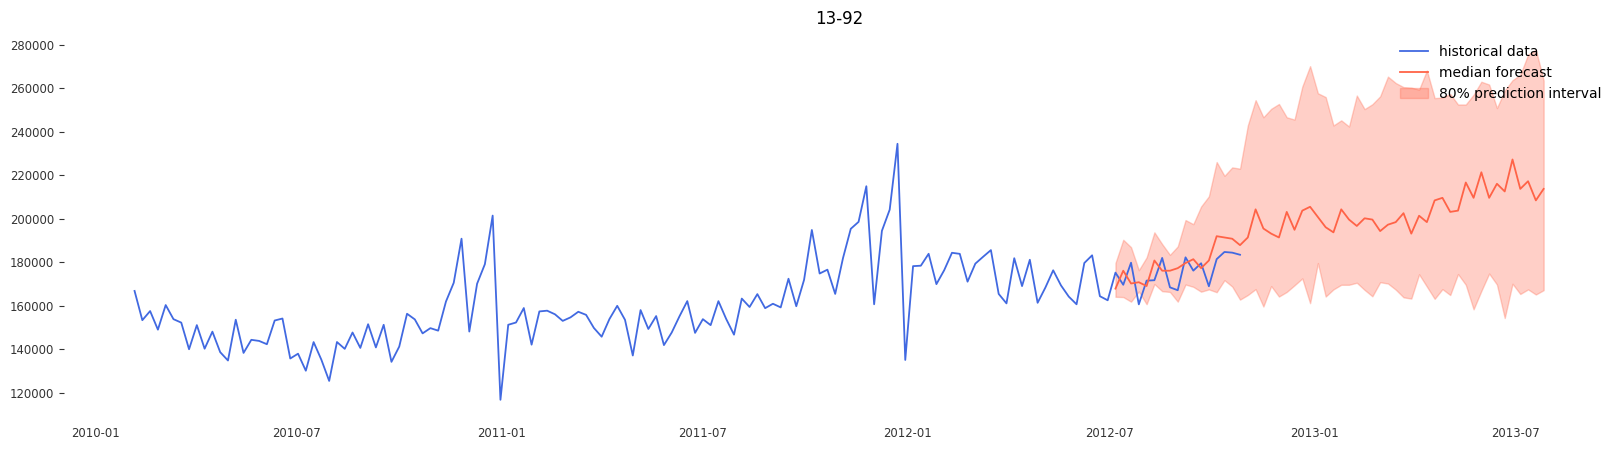

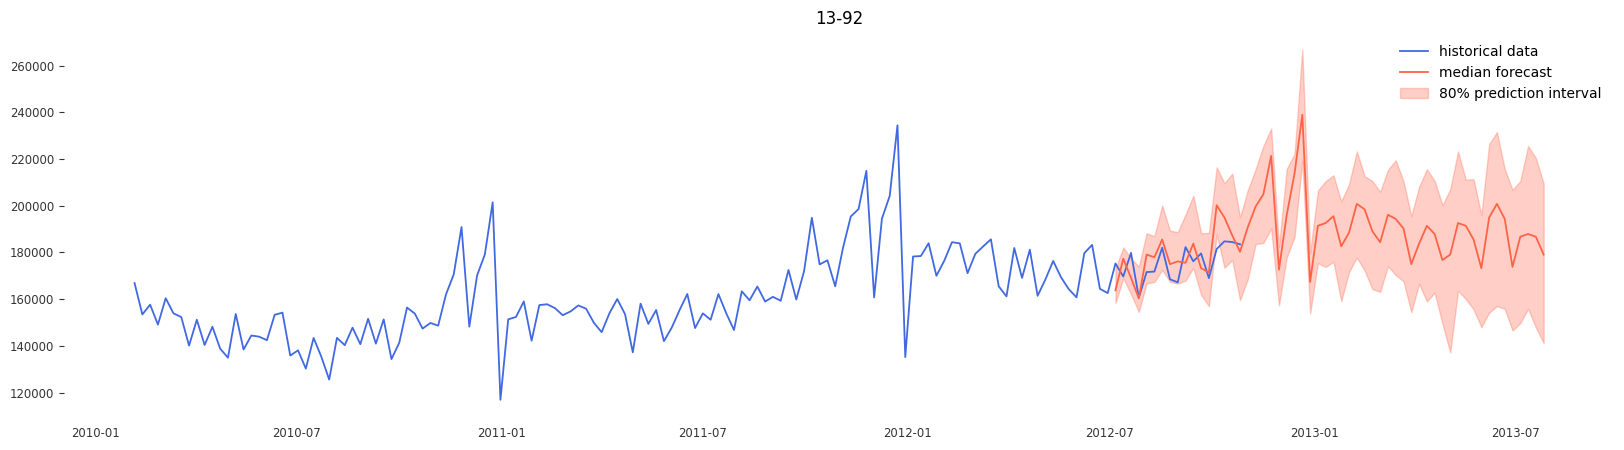

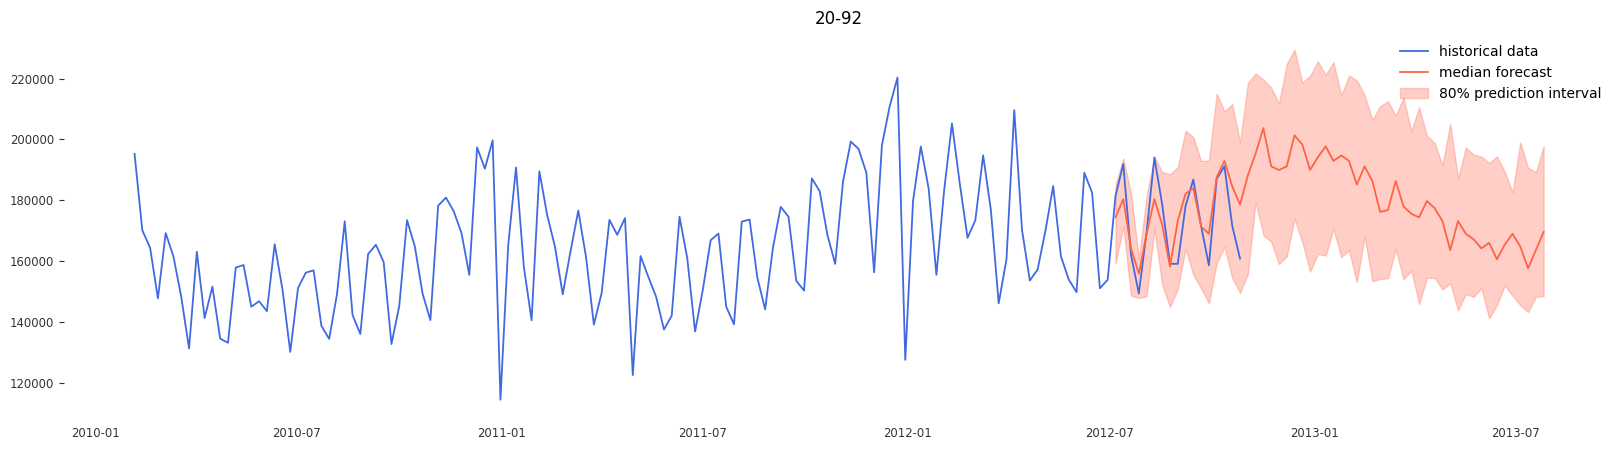

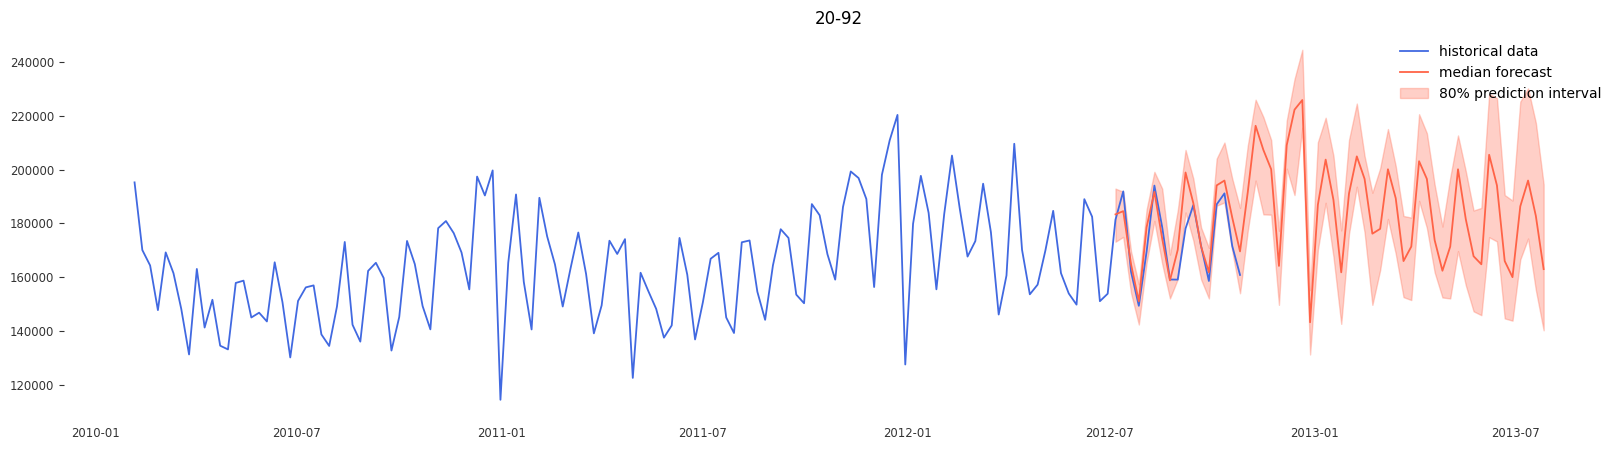

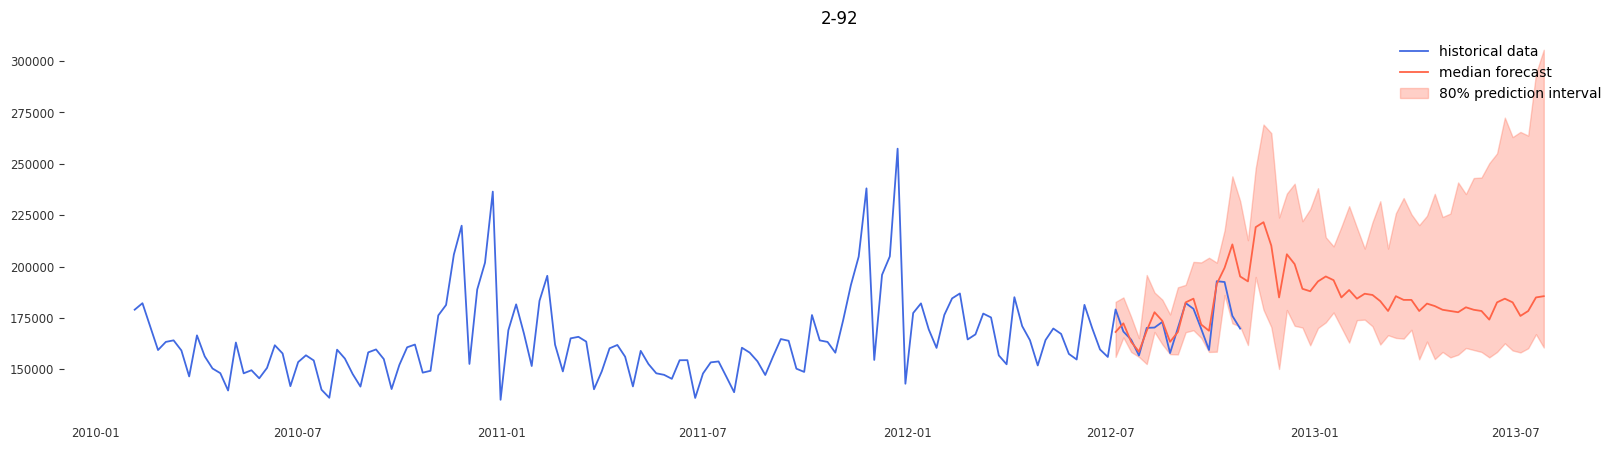

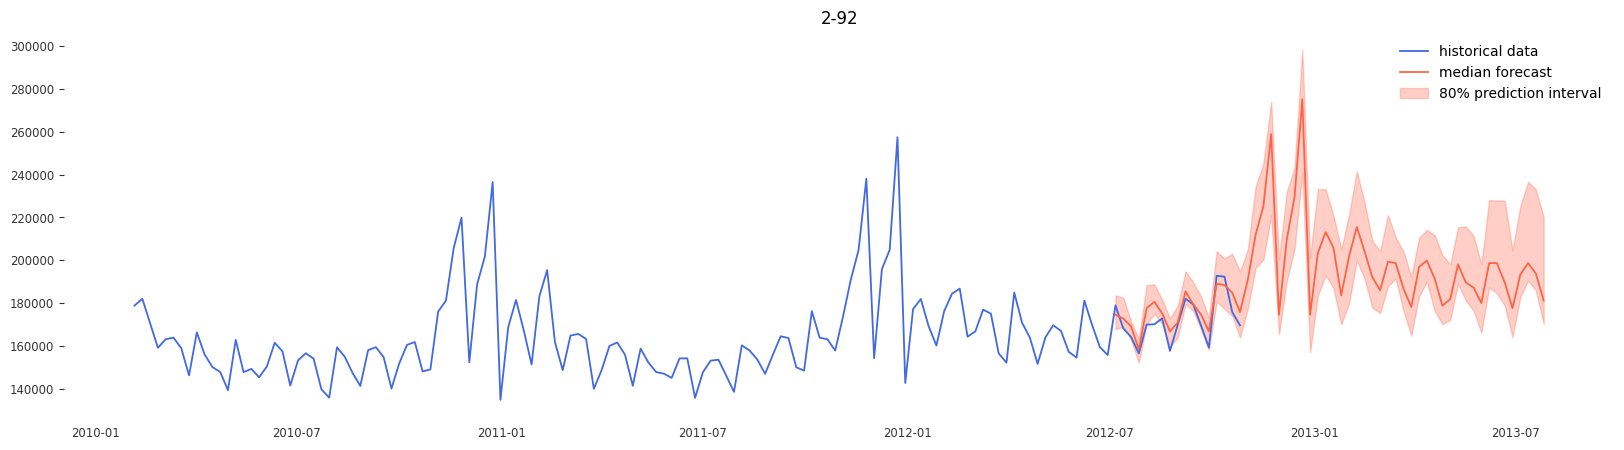

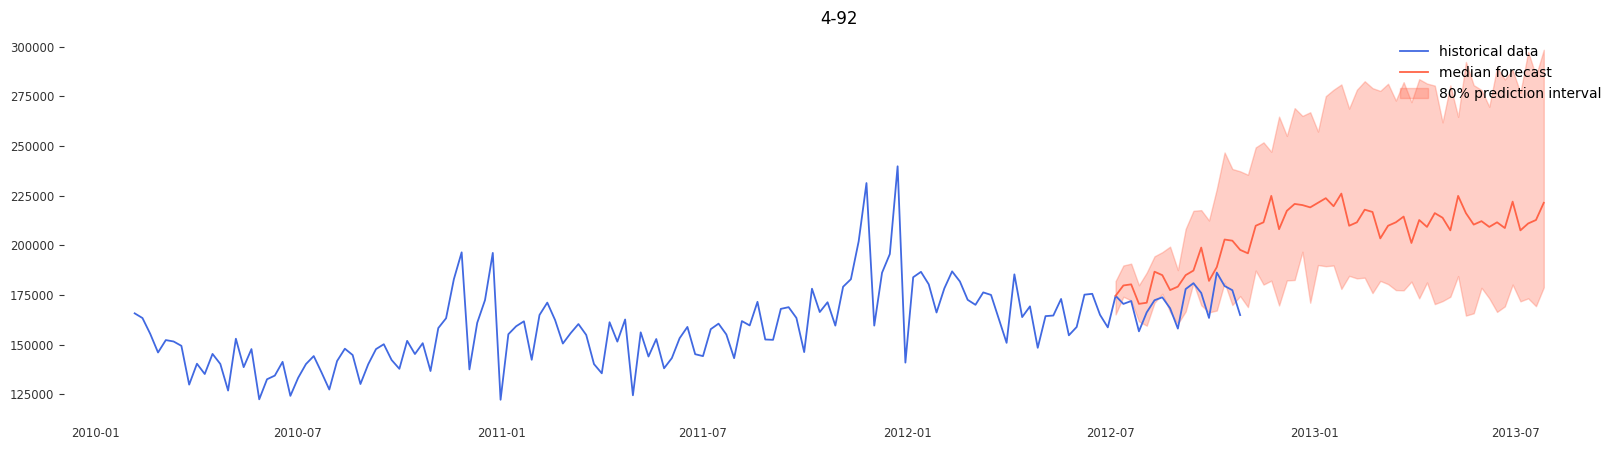

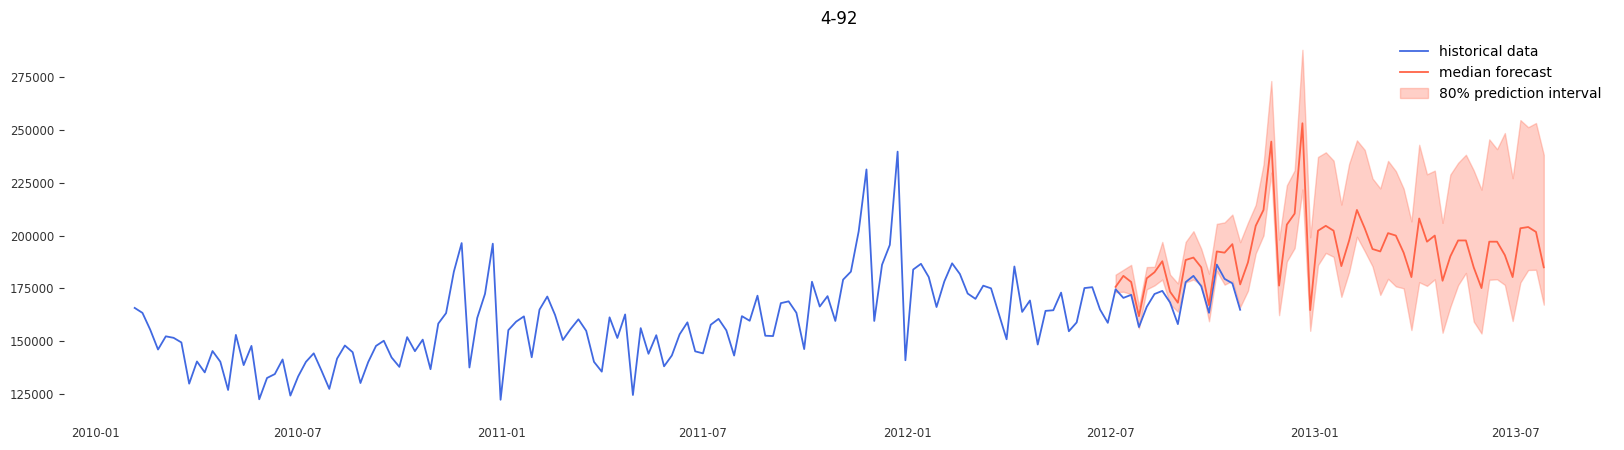

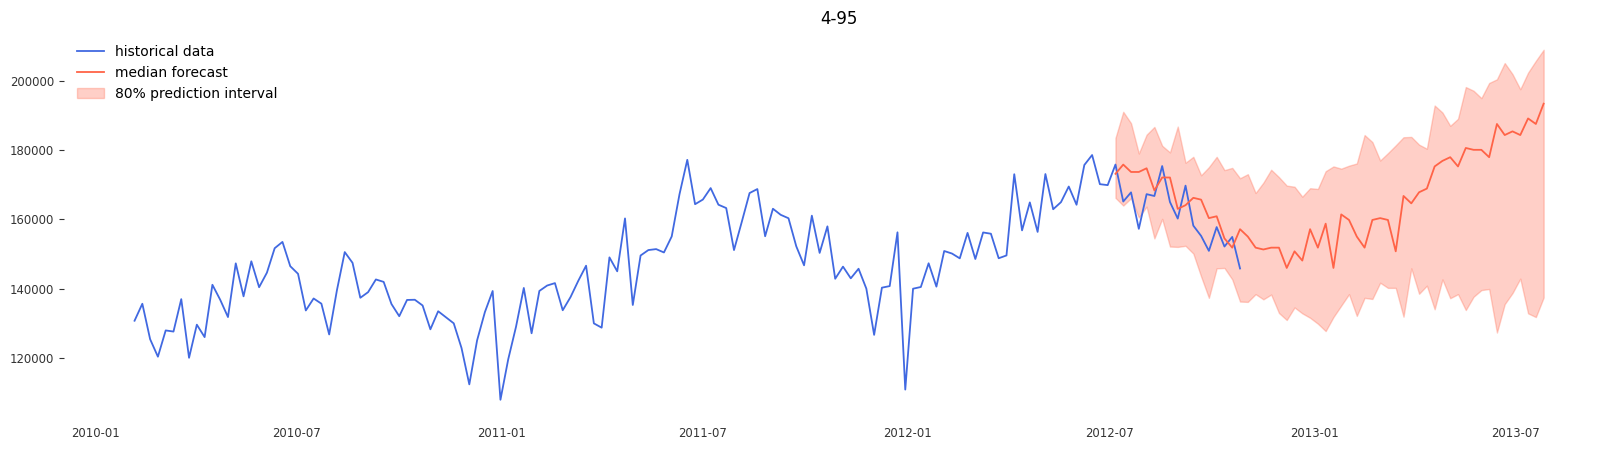

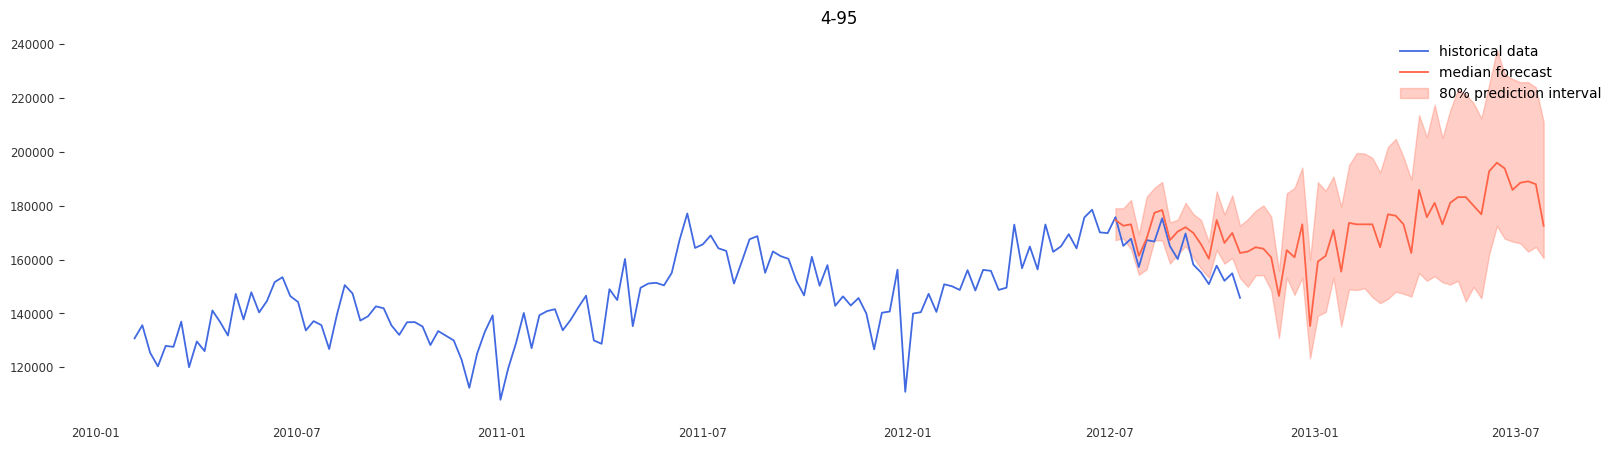

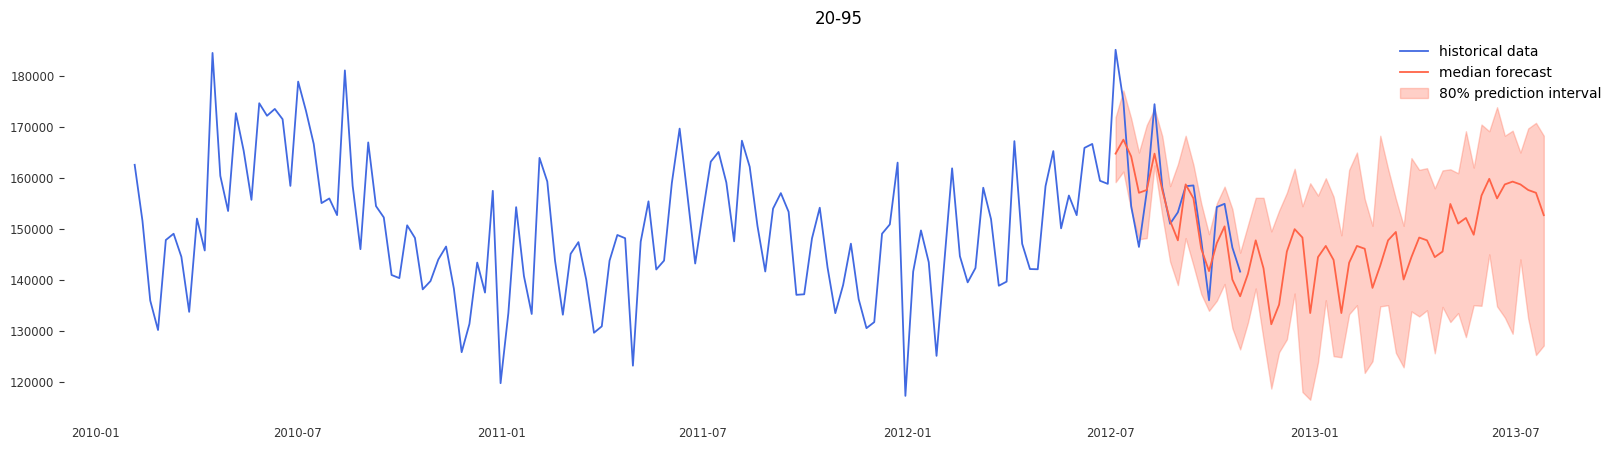

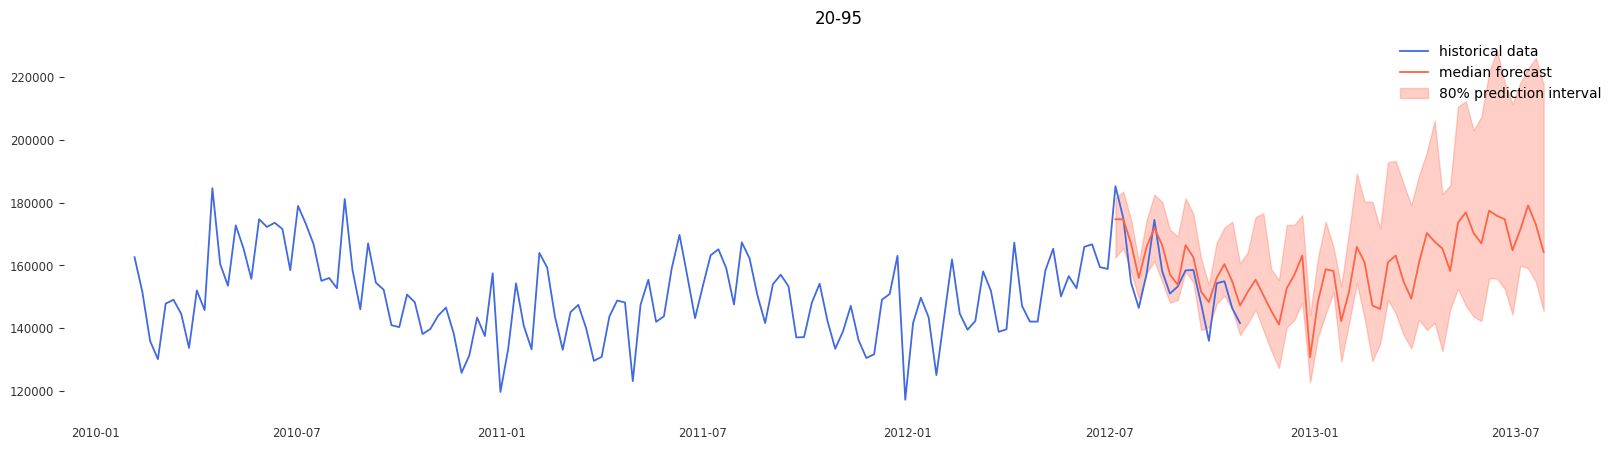

In [10]:
# get series ordered by volume in a descending way
series = test.groupby('unique_id')[TARGET].sum().reset_index().sort_values(by=TARGET, ascending=False)['unique_id'].tolist()

for ts in series[:6]:
    utils.plot_actuals_forecast(df[df["unique_id"]==ts], forecast_tiny[forecast_tiny["unique_id"] == ts], ts)
    utils.plot_actuals_forecast(df[df["unique_id"]==ts], forecast_large[forecast_large["unique_id"] == ts], ts)

### Model Evaluation

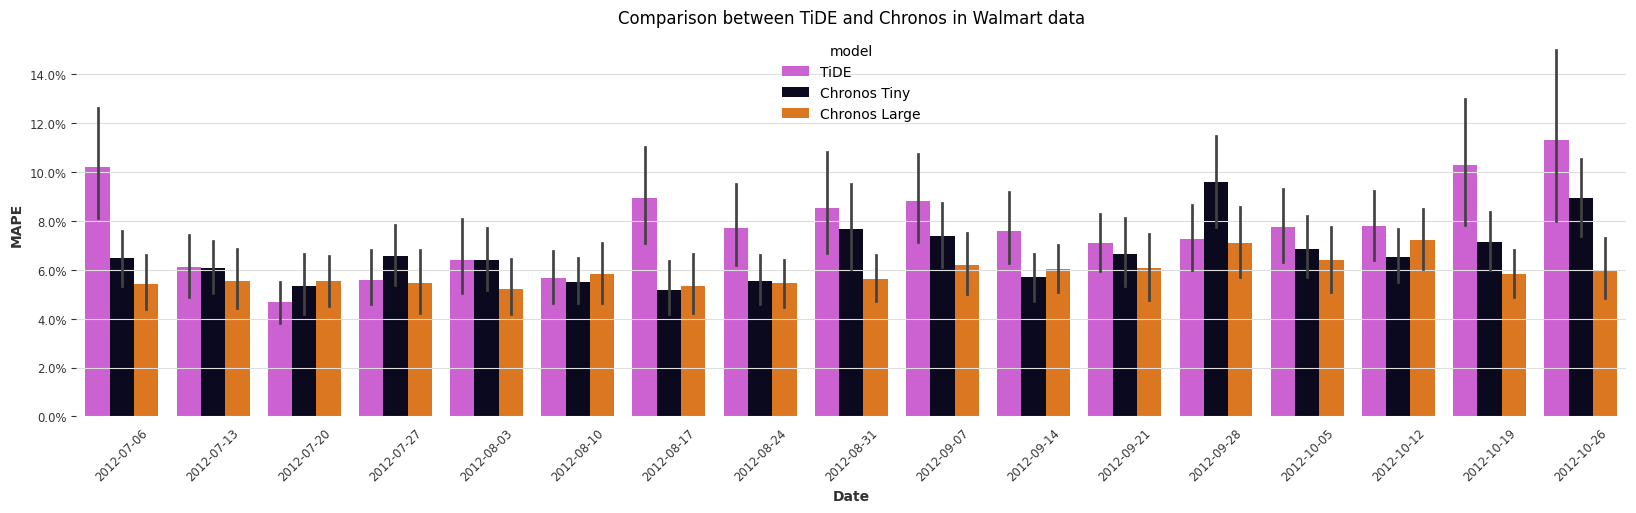

In [11]:
test = pd.read_csv('test.csv').dropna()
tide_model_df = pd.read_csv('tide.csv')
chronos_tiny_df = pd.read_csv('chronos_tiny.csv')
chronos_large_df = pd.read_csv('chronos_large.csv')

tide_model_df.rename(columns={'forecast': 'TiDE'}, inplace=True)
chronos_tiny_df.rename(columns={'forecast': 'Chronos Tiny'}, inplace=True)
chronos_large_df.rename(columns={'forecast': 'Chronos Large'}, inplace=True)

model_eval_df = pd.merge(test[['unique_id', 'Date', 'Weekly_Sales']], tide_model_df[['unique_id', 'Date', 'TiDE']], on=['unique_id', 'Date'], how='inner')
model_eval_df = pd.merge(model_eval_df, chronos_tiny_df[['unique_id', 'Date', 'Chronos Tiny']], on=['unique_id', 'Date'], how='inner')
model_eval_df = pd.merge(model_eval_df, chronos_large_df[['unique_id', 'Date', 'Chronos Large']], on=['unique_id', 'Date'], how='inner')

utils.plot_model_comparison(model_eval_df)